# TSAI Forecasting Implementation
Based on:
- https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/15_PatchTST_a_new_transformer_for_LTSF.ipynb (Notebook Base)
- https://wandb.ai/timeseriesbois/PhysioNet_Challenge/reports/Time-Series-Classification-on-Weights-Biases-with-TSAI--VmlldzoxODM4ODU4?galleryTag=intermediate

Todo:
- Get last part working
- Add WandB

In [5]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('cex4WindDataInterpolated.csv')

# convert time to datetime
df['t'] = pd.to_datetime(df['t'])

# time collumns: t, toy

# target must be float
# df['p'] = df['p'].astype(float)

# variables to use for predictions: Ws, Wd, T

# drop NA
# df.dropna(inplace=True)

# add forward fill
# df.ffill(inplace=True)

df.head()

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.9,135.0,275.8,4.9,135.0,275.8,4.9,135.0,275.8
1,1999-01-01 04:00:00,0.167,1.515,5.0,126.9,275.8,5.0,126.9,275.8,5.0,126.9,275.8
2,1999-01-01 05:00:00,0.208,1.915,5.9,135.7,275.5,5.9,135.7,275.5,5.9,135.7,275.5
3,1999-01-01 06:00:00,0.250,1.613,5.3,146.6,275.0,5.3,146.6,275.0,5.3,146.6,275.0
4,1999-01-01 07:00:00,0.292,1.776,6.1,117.4,274.5,5.9,130.2,274.8,5.9,130.2,274.8


In [8]:
import sklearn
from tsai.basics import *
my_setup(sklearn)

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
sklearn         : 1.2.2
torch           : 2.1.0+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


In [9]:
datetime_col = "t"
freq = '24h'
columns = df.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ],
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df)
df

data directory already exists.
Pipeline saved as data/preproc_pipe.pkl
Initial memory usage: 3.47 MB   
Final memory usage  : 1.88 MB    (-45.8%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,0.125,1.267,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988,4.900000,135.000000,275.799988
1,1999-01-02 03:00:00,1.125,8.152,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000,9.000000,154.300003,273.500000
2,1999-01-03 03:00:00,2.125,9.368,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012,8.100000,183.500000,277.200012
3,1999-01-04 03:00:00,3.125,4.794,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994,8.200000,199.300003,275.399994
4,1999-01-05 03:00:00,4.125,20.201,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000,19.299999,252.500000,278.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,115.125,14.810,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006,13.400000,111.400002,278.100006
1577,2003-04-27 03:00:00,116.125,0.008,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988,2.600000,65.400002,279.799988
1578,2003-04-28 03:00:00,117.125,2.063,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988,6.100000,253.899994,279.799988
1579,2003-04-29 03:00:00,118.125,3.952,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988,8.100000,185.600006,282.799988


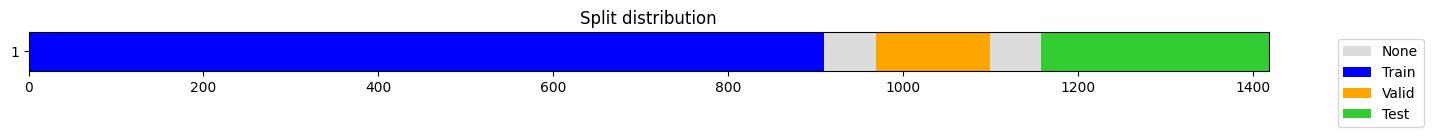

((#910) [0,1,2,3,4,5,6,7,8,9...],
 (#130) [969,970,971,972,973,974,975,976,977,978...],
 (#260) [1158,1159,1160,1161,1162,1163,1164,1165,1166,1167...])

In [10]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
                                valid_size=valid_size, test_size=test_size)
splits

In [11]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ],
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,1999-01-01 03:00:00,-1.573283,-0.591372,-0.754664,-0.694234,-0.858250,-0.754735,-0.694316,-0.857825,-0.754509,-0.689355,-0.857882
1,1999-01-02 03:00:00,-1.563684,0.680770,0.256933,-0.478781,-1.293281,0.256976,-0.478891,-1.292751,0.257288,-0.474142,-1.292796
2,1999-01-03 03:00:00,-1.554086,0.905451,0.034875,-0.152811,-0.593443,0.034893,-0.152963,-0.593082,0.035186,-0.148535,-0.593146
3,1999-01-04 03:00:00,-1.544487,0.060312,0.059548,0.023569,-0.933907,0.059569,0.023395,-0.933463,0.059864,0.027649,-0.933519
4,1999-01-05 03:00:00,-1.534888,2.907066,2.798260,0.617460,-0.442130,2.798591,0.617208,-0.441805,2.799119,0.620879,-0.441873
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2003-04-26 03:00:00,-0.469445,1.910970,1.342548,-0.957689,-0.423214,1.342715,-0.957737,-0.422893,1.343119,-0.952517,-0.422963
1577,2003-04-27 03:00:00,-0.459846,-0.823998,-1.322145,-1.471203,-0.101672,-1.322280,-1.471184,-0.101428,-1.322102,-1.465459,-0.101506
1578,2003-04-28 03:00:00,-0.450248,-0.444295,-0.458587,0.633088,-0.101672,-0.458624,0.632835,-0.101428,-0.458373,0.636490,-0.101506
1579,2003-04-29 03:00:00,-0.440649,-0.095265,0.034875,-0.129368,0.465762,0.034893,-0.129523,0.465869,0.035186,-0.125118,0.465775


In [67]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [13]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((1418, 11, 104), (1418, 11, 60))

In [14]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

In [16]:
learn = TSForecaster(X, y, splits=splits, batch_size=8, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())


In [17]:
learn.summary()

not enough values to plot a chart


PatchTST (Input shape: 8 x 11 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 11 x 60         
RevIN                                     22         True      
____________________________________________________________________________
                     8 x 11 x 106        
ReplicationPad1d                                               
____________________________________________________________________________
                     8 x 24 x 42         
Unfold                                                         
____________________________________________________________________________
                     8 x 11 x 42 x 16    
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

epoch,train_loss,valid_loss,mse,mae,time
0,1.279846,1.358759,1.358759,0.906557,00:12
1,1.157205,1.334700,1.334700,0.898385,00:17
2,1.079923,1.283286,1.283286,0.880926,00:11
3,1.021789,1.186420,1.186420,0.839646,00:10
4,0.988075,1.181850,1.181850,0.840282,00:11
5,0.970224,1.151477,1.151477,0.830630,00:11
6,0.945081,1.132233,1.132233,0.821239,00:10
7,0.925368,1.080912,1.080912,0.798555,00:10
8,0.904452,1.090809,1.090809,0.806824,00:10
9,0.884852,1.133855,1.133855,0.828557,00:10


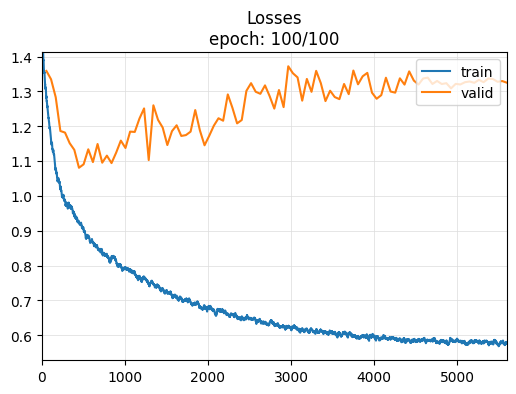

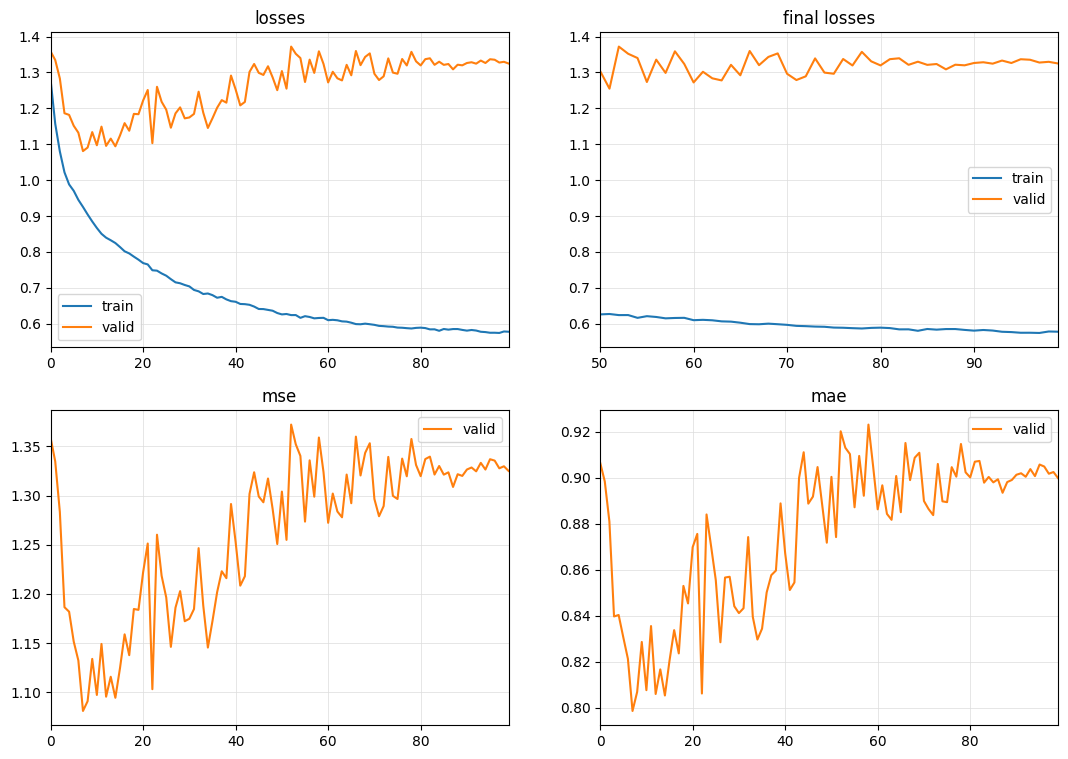

In [18]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

# Evaluate Model

In [19]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
scaled_preds, *_ = learn.get_X_preds(X[splits[1]])
scaled_preds = to_np(scaled_preds)
print(f"scaled_preds.shape: {scaled_preds.shape}")

scaled_y_true = y[splits[1]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["valid", "mse"] = mean_squared_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df.loc["valid", "mae"] = mean_absolute_error(scaled_y_true.flatten(), scaled_preds.flatten())
results_df

scaled_preds.shape: (130, 11, 60)


,mse,mae
valid,1.325013,0.899786


# Test split

In [20]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (260, 11, 60)


,mse,mae
test,1.284024,0.873038


## Visualize Predictions

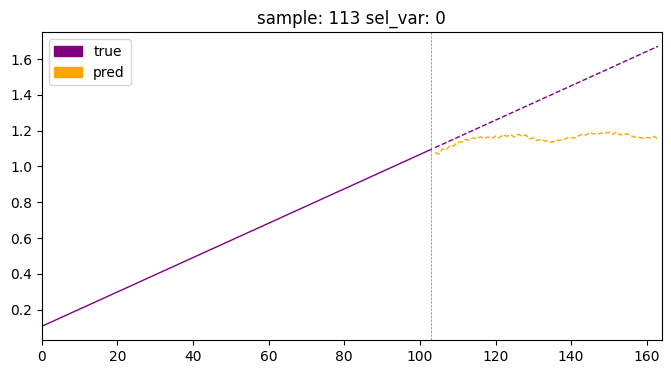

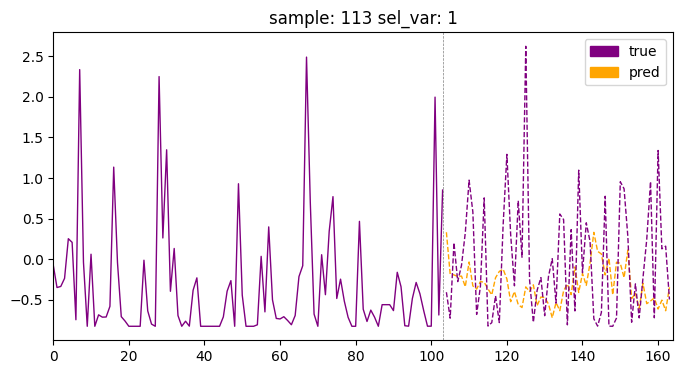

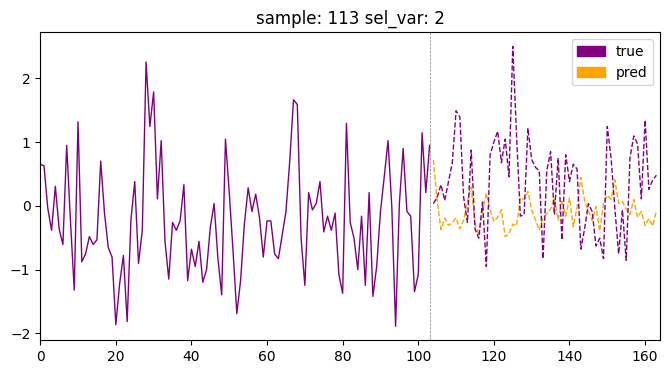

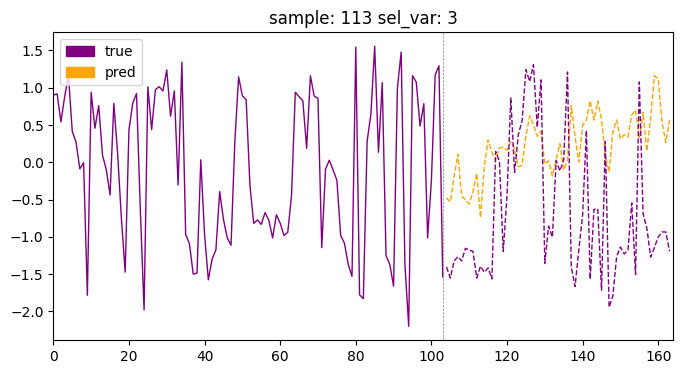

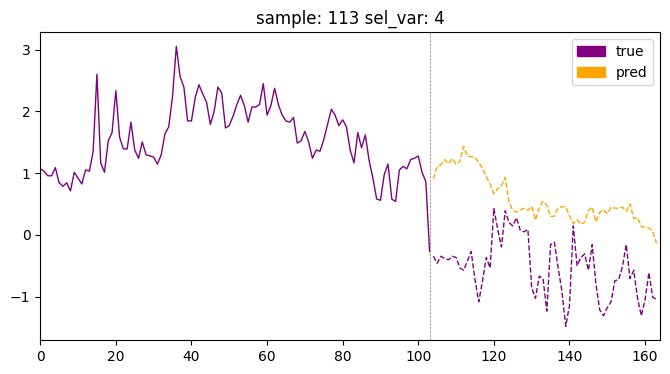

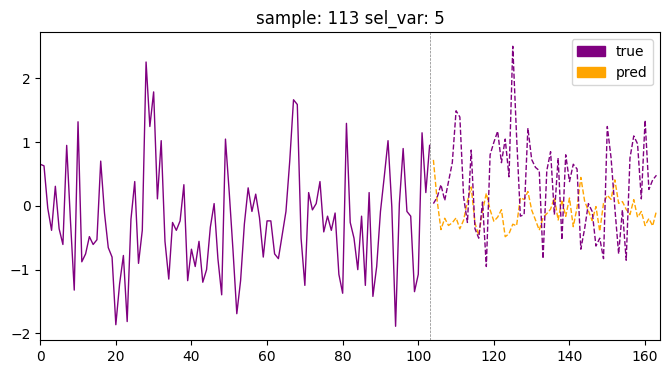

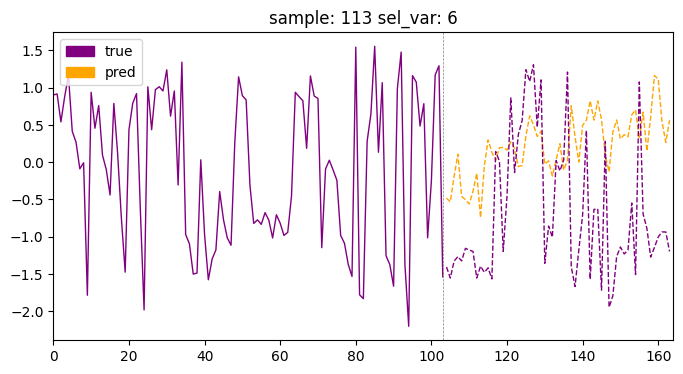

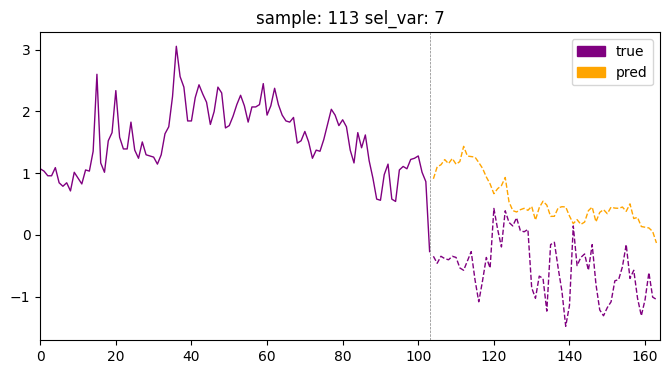

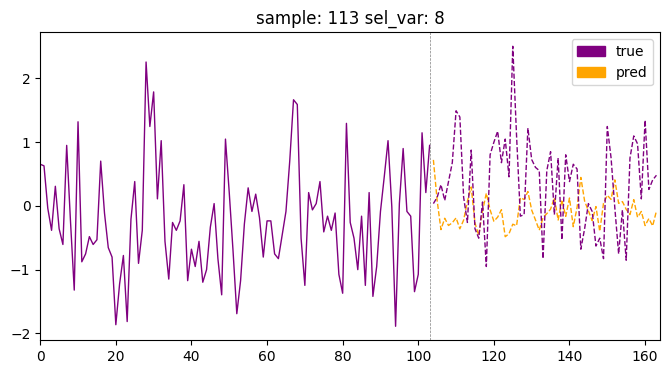

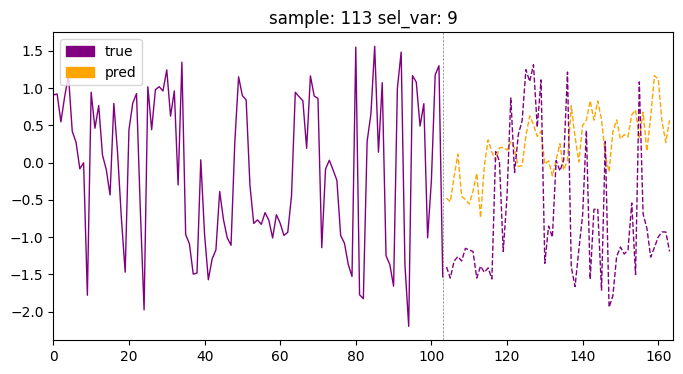

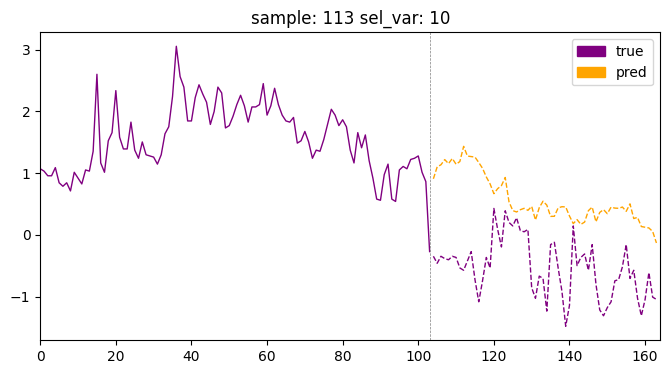

In [21]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

# Inference

In [78]:
fcst_date = "2003-01-01"
fcst_history = 1000
freq = 'H'


dates = pd.date_range(start=None, end=fcst_date, periods=fcst_history, freq=freq)
dates

DatetimeIndex(['2002-11-20 09:00:00', '2002-11-20 10:00:00',
               '2002-11-20 11:00:00', '2002-11-20 12:00:00',
               '2002-11-20 13:00:00', '2002-11-20 14:00:00',
               '2002-11-20 15:00:00', '2002-11-20 16:00:00',
               '2002-11-20 17:00:00', '2002-11-20 18:00:00',
               ...
               '2002-12-31 15:00:00', '2002-12-31 16:00:00',
               '2002-12-31 17:00:00', '2002-12-31 18:00:00',
               '2002-12-31 19:00:00', '2002-12-31 20:00:00',
               '2002-12-31 21:00:00', '2002-12-31 22:00:00',
               '2002-12-31 23:00:00', '2003-01-01 00:00:00'],
              dtype='datetime64[ns]', length=1000, freq='H')

In [79]:
new_df = pd.read_csv('cex4WindDataInterpolated.csv')
new_df['t'] = pd.to_datetime(new_df['t'])
# new_df = get_long_term_forecasting_data(dsid, return_df=True)
new_df = new_df[new_df["t"].isin(dates)].reset_index(drop=True)
new_df

,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,2002-11-20 09:00:00,323.375,0.0,4.3,39.3,273.5,4.3,39.3,273.5,4.3,39.3,273.5
1,2002-11-20 10:00:00,323.417,0.0,4.3,39.3,273.6,4.3,39.3,273.6,4.3,39.3,273.6
2,2002-11-20 11:00:00,323.458,0.0,3.9,29.2,273.7,3.9,29.2,273.7,3.9,29.2,273.7
3,2002-11-20 12:00:00,323.500,0.0,5.1,27.1,273.8,5.1,27.1,273.8,5.1,27.1,273.8
4,2002-11-20 13:00:00,323.542,0.0,5.0,25.0,274.5,6.2,27.0,273.8,6.2,27.0,273.8
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2002-12-31 20:00:00,364.833,NaN,8.5,223.1,267.1,8.5,223.1,267.1,8.7,216.6,266.4
996,2002-12-31 21:00:00,364.875,NaN,8.9,220.5,267.3,8.9,220.5,267.3,8.9,220.5,267.3
997,2002-12-31 22:00:00,364.917,NaN,8.9,219.6,267.6,8.9,219.6,267.6,8.9,219.6,267.6
998,2002-12-31 23:00:00,364.958,NaN,8.7,217.5,267.8,8.7,217.5,267.8,8.7,217.5,267.8


## Preprocess Dataframe

In [80]:
from tsai.inference import load_learner

learn = load_learner('models/patchTST.pt')
new_df = learn.transform(new_df)
new_df

Initial memory usage: 93.88 KB  
Final memory usage  : 50.91 KB   (-45.8%)


,t,toy,p,Ws1,Wd1,T1,Ws2,Wd2,T2,Ws3,Wd3,T3
0,2002-11-20 09:00:00,1.529461,-0.825476,-0.902702,-1.762567,-1.293281,-0.902790,-1.762510,-1.292751,-0.902577,-1.756498,-1.292796
1,2002-11-21 09:00:00,1.539060,-0.576776,0.404971,-1.216679,-1.387853,0.405031,-1.216693,-1.387300,0.405356,-1.211218,-1.387343
2,2002-11-22 09:00:00,1.548659,1.026291,1.539933,-1.106162,-1.104136,1.540122,-1.106190,-1.103651,1.540543,-1.100824,-1.103702
3,2002-11-23 09:00:00,1.558257,-0.538528,0.182913,-1.284775,-1.160877,0.182948,-1.284781,-1.160379,0.183254,-1.279239,-1.160428
4,2002-11-24 09:00:00,1.567856,-0.520790,-0.014471,-1.090533,-0.706931,-0.014459,-1.090563,-0.706542,-0.014170,-1.085213,-0.706604
5,2002-11-25 09:00:00,1.577454,-0.825476,-0.557279,-0.854986,-0.877160,-0.557328,-0.855047,-0.876730,-0.557085,-0.849928,-0.876787
6,2002-11-26 09:00:00,1.587053,-0.761915,-0.433914,-1.923319,-0.479961,-0.433949,-1.923242,-0.479627,-0.433695,-1.917072,-0.479694
7,2002-11-27 09:00:00,1.596652,-0.678030,-0.927375,-0.038945,-0.215154,-0.927466,-0.039112,-0.214883,-0.927255,-0.034796,-0.214958
8,2002-11-28 09:00:00,1.606250,0.301807,0.947779,-0.771261,-0.763678,0.947901,-0.771333,-0.763275,0.948271,-0.766296,-0.763335
9,2002-11-29 09:00:00,1.615849,0.455535,0.701048,-0.997877,-0.612359,0.701142,-0.997920,-0.611993,0.701492,-0.992660,-0.612057


## Apply Sliding Window

In [81]:
x_feat = new_df.columns[1:]
new_X, _ = prepare_forecasting_data(new_df, fcst_history=fcst_history, fcst_horizon=0, x_vars=x_vars, y_vars=None)
new_X.shape

ValueError: window shape cannot be larger than input array shape

In [82]:
new_scaled_preds, *_ = learn.get_X_preds(new_X)

new_scaled_preds = to_np(new_scaled_preds).swapaxes(1,2).reshape(-1, len(y_vars))
dates = pd.date_range(start=fcst_date, periods=fcst_horizon + 1, freq='7D')[1:]
preds_df = pd.DataFrame(dates, columns=[datetime_col])
preds_df.loc[:, y_vars] = new_scaled_preds
preds_df = learn.inverse_transform(preds_df)
preds_df

NameError: name 'new_X' is not defined